In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('kickstarter_data_full.csv')
data.head()

,Unnamed: 0,id,photo,name,blurb,goal,pledged,state,slug,disable_communication,...,launch_to_deadline,launch_to_state_change,create_to_launch_days,launch_to_deadline_days,launch_to_state_change_days,SuccessfulBool,USorGB,TOPCOUNTRY,LaunchedTuesday,DeadlineWeekend
0,0,1454391034,"{""small"":""https://ksr-ugc.imgix.net/assets/011...",Auntie Di's Music Time Sign ASL for Hearing an...,MTS ASL Curriculum Workbook is a reproducible ...,1500.0,0.0,failed,auntie-dis-music-time-sign-asl-for-hearing-and...,False,...,36 days 20:47:24.000000000,36 days 20:47:24.000000000,17,36,36,0,1,1,0,0
1,1,1655206086,"{""small"":""https://ksr-ugc.imgix.net/assets/012...",Jump Start Kindergarten Toolkit,"This kit teaches how to print, correct an ugly...",500.0,0.0,failed,jump-start-kindergarten-toolkit,False,...,60 days 00:00:00.000000000,60 days 00:00:02.000000000,10,60,60,0,1,1,0,0
2,2,311581827,"{""small"":""https://ksr-ugc.imgix.net/assets/012...",Ojukwu Balewa Awolowo (O.B.A.) Public Library ...,"Establishing a free, world-class, public libra...",100000.0,120.0,failed,ojukwu-balewa-awolowo-oba-public-library-of-ni...,False,...,60 days 00:00:00.000000000,60 days 00:00:01.000000000,1,60,60,0,1,1,0,0
3,3,859724515,"{""small"":""https://ksr-ugc.imgix.net/assets/011...","MASTIZE - [mas-TAHYZ, MAS-tahyz] - to spread",Goal: Introducing a new word into the English ...,5000.0,0.0,failed,mastize-mas-tahyz-mas-tahyz-to-spread,False,...,30 days 00:00:00.000000000,30 days 00:00:00.000000000,0,30,30,0,1,1,0,0
4,4,1613604977,"{""small"":""https://ksr-ugc.imgix.net/assets/012...","Synopse der EU-DSGVO - Artikel, Erwägungsgründ...",Zu den Artikeln der DSGVO sind die korrespondi...,3222.0,356.0,failed,synopse-der-eu-dsgvo-artikel-erwagungsgrunde-bdsg,False,...,32 days 06:02:33.000000000,32 days 06:02:33.000000000,0,32,32,0,0,0,0,0


In [3]:
data['disable_communication'] = data['disable_communication'] * 1 #converts type bool to 0 for false and 1 for true
data['staff_pick'] = data['staff_pick'] * 1 #converts type bool to 0 for false and 1 for true
data['spotlight'] = data['spotlight'] * 1 

In [4]:
state_to_num = {'failed': 0, 'canceled': 1, 'successful': 2, 'live': 3, 'suspended': 4}
data['state'] = data['state'].map(state_to_num)

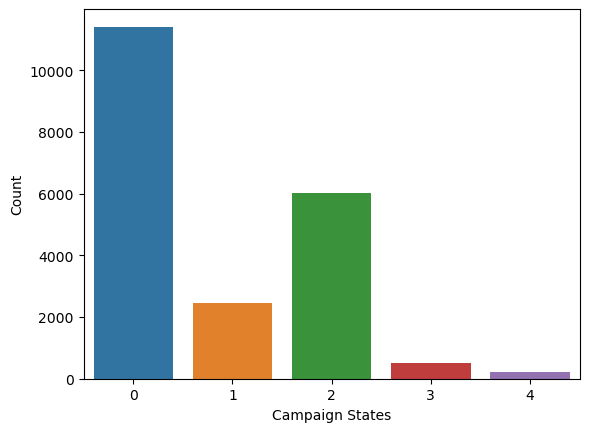

In [5]:
sns.countplot(data['state']);
plt.xlabel('Campaign States'); 
plt.ylabel('Count');

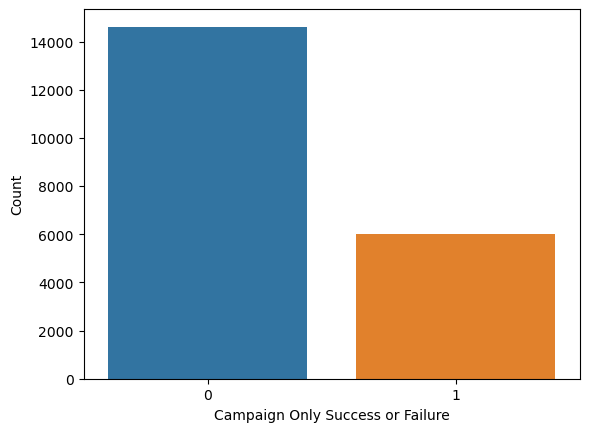

In [6]:
sns.countplot(data['SuccessfulBool']);
plt.xlabel('Campaign Only Success or Failure'); 
plt.ylabel('Count');

In [7]:
print("Only " 
      + str(np.round(data['SuccessfulBool'].value_counts()[1] / len(data) * 100, decimals=2)) 
      + "% of campaigns were successful.")

Only 29.17% of campaigns were successful.


<h1>Pre Processing

In [8]:
data.drop(columns=['Unnamed: 0', 'id','name', 'blurb','photo', 'slug', 'disable_communication', 
                 'currency_symbol', 'currency_trailing_code', 'creator', 
                 'location', 'category', 'profile', 'urls', 'source_url', 
                 'friends', 'is_starred', 'is_backing', 'permissions'], 
        inplace=True)

In [9]:
for column in data.columns:
    if data[column].dtype == 'object':
        data[column].fillna(data[column].mode()[0], inplace=True)
    elif data[column].dtype.name == 'category':
        data[column].fillna(data[column].mode()[0], inplace=True)
    else:
        data[column].fillna(data[column].mean(), inplace=True)

In [10]:

data['staff_pick'] = data['staff_pick'].astype(int)
data['spotlight'] = data['spotlight'].astype(int)

# Create an instance of the OrdinalEncoder
encoder = OrdinalEncoder()

data['country'] = encoder.fit_transform(data[['country']])
data['currency'] = encoder.fit_transform(data[['currency']])
data['deadline_weekday'] = encoder.fit_transform(data[['deadline_weekday']])
data['state_changed_at_weekday'] = encoder.fit_transform(data[['state_changed_at_weekday']])
data['created_at_weekday'] = encoder.fit_transform(data[['created_at_weekday']])
data['launched_at_weekday'] = encoder.fit_transform(data[['launched_at_weekday']])
 

In [11]:
data['deadline'] = pd.to_datetime(data['deadline']).astype('int64') * 1e-9
data['state_changed_at'] = pd.to_datetime(data['state_changed_at']).astype('int64') * 1e-9
data['created_at'] = pd.to_datetime(data['created_at']).astype('int64') * 1e-9
data['launched_at'] = pd.to_datetime(data['launched_at']).astype('int64') * 1e-9

data['deadline_yr'] = pd.to_datetime(data['deadline']).dt.year.astype(float)
data['deadline_month'] = pd.to_datetime(data['deadline']).dt.month.astype(float)
data['deadline_day'] = pd.to_datetime(data['deadline']).dt.day.astype(float)
data['deadline_hr'] = pd.to_datetime(data['deadline']).dt.hour.astype(float)

data['state_changed_at_yr'] = pd.to_datetime(data['state_changed_at']).dt.year.astype(float)
data['state_changed_at_month'] = pd.to_datetime(data['state_changed_at']).dt.month.astype(float)
data['state_changed_at_day'] = pd.to_datetime(data['state_changed_at']).dt.day.astype(float)
data['state_changed_at_hr'] = pd.to_datetime(data['state_changed_at']).dt.hour.astype(float)

data['created_at_yr'] = pd.to_datetime(data['created_at']).dt.year.astype(float)
data['created_at_month'] = pd.to_datetime(data['created_at']).dt.month.astype(float)
data['created_at_day'] = pd.to_datetime(data['created_at']).dt.day.astype(float)
data['created_at_hr'] = pd.to_datetime(data['created_at']).dt.hour.astype(float)

data['launched_at_yr'] = pd.to_datetime(data['launched_at']).dt.year.astype(float)
data['launched_at_month'] = pd.to_datetime(data['launched_at']).dt.month.astype(float)
data['launched_at_day'] = pd.to_datetime(data['launched_at']).dt.day.astype(float)
data['launched_at_hr'] = pd.to_datetime(data['launched_at']).dt.hour.astype(float)

data['create_to_launch'] = pd.to_timedelta(data['create_to_launch']).dt.total_seconds() / 86400.0
data['launch_to_deadline'] = pd.to_timedelta(data['launch_to_deadline']).dt.total_seconds() / 86400.0
data['launch_to_state_change'] = pd.to_timedelta(data['launch_to_state_change']).dt.total_seconds() / 86400.0

data['create_to_launch_days'] = data['create_to_launch_days'].astype(float)
data['launch_to_deadline_days'] = data['launch_to_deadline_days'].astype(float)
data['launch_to_state_change_days'] = data['launch_to_state_change_days'].astype(float)

In [12]:
# Define the features and target variable

X = data.drop(["deadline", "state_changed_at", "created_at", "launched_at", "name_len_clean", "blurb_len_clean", "SuccessfulBool"], axis=1)
y = data["SuccessfulBool"]

# Define the model
model = LogisticRegression()

# Define the RFE object
rfe = RFE(estimator=model, n_features_to_select=10)

# Fit the RFE object to the data
rfe.fit(X, y)

# Print the selected features
print("Selected Features:")
for i in range(X.shape[1]):
    if rfe.support_[i]:
        print(X.columns[i])


Selected Features:
state
staff_pick
static_usd_rate
spotlight
create_to_launch
launch_to_state_change
create_to_launch_days
launch_to_state_change_days
USorGB
TOPCOUNTRY


In [12]:
# Set output variable
y = data["SuccessfulBool"]

# Drop unnecessary columns
# X = data[["state", "staff_pick", "spotlight", "create_to_launch", "launch_to_state_change", "create_to_launch_days", "launch_to_state_change_days","launch_to_state_change_days","USorGB","TOPCOUNTRY"]]
X = data[["state", "staff_pick","static_usd_rate","spotlight","create_to_launch","launch_to_state_change","create_to_launch_days","launch_to_state_change_days","USorGB","TOPCOUNTRY"]]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [21]:
# Separate the safe and risky loans
safe_loans = data[data['SuccessfulBool'] == 0]
risky_loans = data[data['SuccessfulBool'] == 1]

# Determine the number of risky loans
num_risky_loans = len(risky_loans)

# Randomly select a subset of safe loans
safe_loans_under = safe_loans.sample(n=num_risky_loans, random_state=42)

# Concatenate the risky loans and the under-sampled safe loans
data_balanced = pd.concat([risky_loans, safe_loans_under])

# Shuffle the rows of the balanced dataset
data_balanced = data_balanced.sample(frac=1, random_state=42)

# Print out the percentage of safe and risky loans in the balanced dataset
pct_safe_loans = len(data_balanced[data_balanced['SuccessfulBool'] == 0]) / len(data_balanced) * 100
pct_risky_loans = len(data_balanced[data_balanced['SuccessfulBool'] == 1]) / len(data_balanced) * 100
print("Percentage of Successful : {:.2f}%".format(pct_safe_loans))
print("Percentage of unuccessful : {:.2f}%".format(pct_risky_loans))
print("Successful: ", len(data_balanced[data_balanced['SuccessfulBool'] == 0]))

Percentage of Successful : 50.00%
Percentage of unuccessful : 50.00%
Successful:  6018


In [49]:
print(X_train.shape)


(16505, 10)


In [29]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

SVC()

In [30]:
score = clf.score(X_test, y_test)
y_pred=clf.predict(X_test)
# print("Accuracy:", score)
# accuracy = accuracy_score(y_test, y_pred)

# Calculate the precision
precision = precision_score(y_test, y_pred)

# Calculate the recall
recall = recall_score(y_test, y_pred)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)

# Print the results
print("Accuracy: {:.2f}%".format(score * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 score: {:.2f}%".format(f1 * 100))

Accuracy: 91.35%
Precision: 98.29%
Recall: 71.59%
F1 score: 82.84%


In [31]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree classifier
tree_clf = DecisionTreeClassifier(random_state=42)

# Train the Decision Tree classifier
tree_clf.fit(X_train, y_train)

# Use the trained classifier to make predictions on the testing set
y_pred = tree_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

# Calculate the precision
precision = precision_score(y_test, y_pred)

# Calculate the recall
recall = recall_score(y_test, y_pred)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 score: {:.2f}%".format(f1 * 100))

Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1 score: 100.00%


In [50]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression classifier
log_reg_clf = LogisticRegression(random_state=42)

# Train the Logistic Regression classifier
log_reg_clf.fit(X_train, y_train)
# Use the trained classifier to make predictions on the testing set
y_pred = log_reg_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

# Calculate the precision
precision = precision_score(y_test, y_pred)

# Calculate the recall
recall = recall_score(y_test, y_pred)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 score: {:.2f}%".format(f1 * 100))

Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1 score: 100.00%


In [51]:
# Define the cross-validation object
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the model using cross-validation
scores = cross_val_score(log_reg_clf, X, y, cv=cv, scoring="accuracy")

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores: [1. 1. 1. 1. 1.]
Mean accuracy: 1.0


In [33]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
forest_clf = RandomForestClassifier(random_state=42)

# Train the Random Forest classifier
forest_clf.fit(X_train, y_train)
# Use the trained classifier to make predictions on the testing set
y_pred = forest_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

# Calculate the precision
precision = precision_score(y_test, y_pred)

# Calculate the recall
recall = recall_score(y_test, y_pred)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 score: {:.2f}%".format(f1 * 100))

Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1 score: 100.00%


In [34]:
from sklearn.naive_bayes import GaussianNB

# Initialize the Naive Bayes classifier
nb_clf = GaussianNB()

# Train the Naive Bayes classifier
nb_clf.fit(X_train, y_train)

# Use the trained classifier to make predictions on the testing set
y_pred = nb_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

# Calculate the precision
precision = precision_score(y_test, y_pred)

# Calculate the recall
recall = recall_score(y_test, y_pred)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)

# Print the results
print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 score: {:.2f}%".format(f1 * 100))

Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1 score: 100.00%


In [16]:
# Define the cross-validation object
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the model using cross-validation
scores = cross_val_score(clf, X, y, cv=cv, scoring="accuracy")

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores: [0.921008   0.91495033 0.92244304 0.91638391 0.90838585]
Mean accuracy: 0.916634224026988


In [17]:
# Define the KNN model with k=5
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the KNN model to the training data
knn.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = knn.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy of the model
print("Accuracy:", accuracy)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred))

Accuracy: 0.9466925127211049
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      2923
           1       0.95      0.87      0.90      1204

    accuracy                           0.95      4127
   macro avg       0.95      0.92      0.93      4127
weighted avg       0.95      0.95      0.95      4127



In [18]:
# Define the cross-validation object
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Evaluate the model using cross-validation
scores = cross_val_score(knn, X, y, cv=cv, scoring="accuracy")

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores: [0.94525194 0.95251938 0.9592826  0.94764905 0.94813379 0.95249636
 0.94958798 0.95685894 0.94667959 0.94425594]
Mean accuracy: 0.9502715573767413


<H1>Multi Class Classification

In [19]:
X = data.drop(["deadline", "state_changed_at", "created_at", "launched_at", "name_len_clean", "blurb_len_clean",'state'], axis=1)
y = data['state']

# Initialize the estimator
estimator = RandomForestClassifier()

# Initialize the RFE object
rfe = RFE(estimator, n_features_to_select=10, verbose=1)

# Fit the RFE object to the data
rfe.fit(X, y)

# Print the selected features
print('Selected Features:')
for i, col in enumerate(X.columns):
    if rfe.support_[i]:
        print(col)

Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 fe

In [19]:
# Set output variable
y = data["state"].iloc[:1000]

# Drop unnecessary columns
X = data[["goal", "pledged", "backers_count", "usd_pledged", "spotlight", "launch_to_deadline", "launch_to_state_change","launch_to_state_change_days","launch_to_deadline_days","SuccessfulBool"]].iloc[:1000]

# Split data into train and test sets
# Perform stratified sampling to ensure balanced classes in the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Print the shapes of the train and test sets
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (800, 10)
X_test shape: (200, 10)
y_train shape: (800,)
y_test shape: (200,)


In [19]:
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train)

SVC(kernel='linear')

In [22]:
score = clf.score(X_test, y_test)
# print("Accuracy:", score)
y_pred=clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

# Calculate the precision
precision = precision_score(y_test, y_pred, average='micro')

# Calculate the recall
recall = recall_score(y_test, y_pred, average='micro')

# Calculate the F1 score
f1 = f1_score(y_test, y_pred, average='micro')

# Print the results
print("Accuracy: {:.2f}%".format(score * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1 score: {:.2f}%".format(f1 * 100))

Accuracy: 95.00%
Precision: 95.00%
Recall: 95.00%
F1 score: 95.00%


In [25]:
# Create and fit a KNN model
k = 4  # number of neighbors
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

# Use the trained model to predict the classes of the test data
# predictions = knn.predict(X_test)

y_pred = knn.predict(X_test)
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy of the model
print("Accuracy:", accuracy)

# Evaluate the performance of the model
print(classification_report(y_test, y_pred))

Accuracy: 0.905
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       116
           1       0.25      0.06      0.10        16
           2       0.99      1.00      0.99        68

    accuracy                           0.91       200
   macro avg       0.71      0.68      0.67       200
weighted avg       0.87      0.91      0.88       200



In [26]:
# Define the cross-validation object
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Evaluate the model using cross-validation
scores = cross_val_score(knn, X, y, cv=cv, scoring="accuracy")

# Print the cross-validation scores
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validation scores: [0.96 0.88 0.95 0.86 0.87 0.91 0.92 0.97 0.91 0.88]
Mean accuracy: 0.9110000000000001
